<a href="https://colab.research.google.com/github/Polinia/skillfactory_rds/blob/main/module_5/car_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Car classification & price prediction
<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>





## Import Libraries

In [96]:
import numpy as np 
import pandas as pd 
import sys
import time
import datetime
import requests as r
import json
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
!pip install catboost -q
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import pandas_profiling
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone

In [97]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.15 (default, Oct 12 2022, 19:14:39) 
Numpy        : 1.21.6


In [98]:
# fix the version of the packages so that the experiments are reproducible:
!pip freeze > requirements.txt
# fixing RANDOM_SEED
RANDOM_SEED = 42

In [99]:
#function for metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Parsing code

In [100]:
# in accordance with the condition of the problem, we need data for Moscow:

START_URL='https://auto.ru/moskva/cars/used/'

pages_url_list=[]

In [101]:
"""while len(pages_url_list)<5000: 
    for i in range(1,99):   
        response = r.get( START_URL+'?page=%s'%i)
        page = BeautifulSoup(response.text, 'html.parser')
        for link in page.findAll('a',{"class": "Link OfferThumb"}):
            try:
                if link['href'] not in pages_url_list: 
                    pages_url_list.append(link['href'])
            except:
                pass
    print(len(pages_url_list))   
    time.sleep(10)"""

'while len(pages_url_list)<5000: \n    for i in range(1,99):   \n        response = r.get( START_URL+\'?page=%s\'%i)\n        page = BeautifulSoup(response.text, \'html.parser\')\n        for link in page.findAll(\'a\',{"class": "Link OfferThumb"}):\n            try:\n                if link[\'href\'] not in pages_url_list: \n                    pages_url_list.append(link[\'href\'])\n            except:\n                pass\n    print(len(pages_url_list))   \n    time.sleep(10)'

We create a dataframe with considering the previously analyzed features, some of them in the test are not informative, we will not waste time on them. We use the BeautifulSoup library. Subject to the condition that the car must be with a price. We also added error protection in the form of a try/except function. As a protection against captcha on the site, we have prescribed a delay after each cycle of 0.1 seconds

In [102]:
"""cars_list = []
for item in pages_url_list:
    response = r.get(item)
    response.encoding = 'utf8'
    page = BeautifulSoup(response.text, 'html.parser')
    if page.find('div', class_='CardSold') == None:
        try:
            json_data = json.loads(
                page.find('script', type="application/ld+json").string)
        except:
            print(item)
            pass
        cls_str = 'CardInfoRow_'
        span_str = 'CardInfoRow__cell'
        try:
            cars_list.append({
            'bodyType': json_data['bodyType'],
            'brand': json_data['brand'],
            'car_url': json_data['offers']['url'],
            'color': json_data['color'],
            'description': json_data['description'],
            'engineDisplacement': json_data['vehicleEngine']['engineDisplacement'],
            'enginePower': json_data['vehicleEngine']['enginePower'],
            'fuelType': json_data['fuelType'],
            'image': json_data['image'],
            'mileage': page.find(
                'li', class_=cls_str+'kmAge').find_all('span')[1].text,
            'modelDate': json_data['modelDate'],
            'model_name': json_data['name'],
            'name': json_data['vehicleEngine']['name'],
            'numberOfDoors': json_data['numberOfDoors'],
            'parsing_unixtime': int(time.time()),
            'priceCurrency': json_data['offers']['priceCurrency'],
            'productionDate': json_data['productionDate'],
            'sell_id': page.find(
                'div', title='Идентификатор объявления').text,
            'vehicleConfiguration': json_data['vehicleConfiguration'],
            'vehicleTransmission': json_data['vehicleTransmission'],
            'Владельцы': page.find(
                'li', class_=cls_str+'ownersCount').find_all('span')[1].text,
            'ПТС': page.find(
                'li', class_=cls_str+'pts').find_all('span')[1].text,
            'Привод': page.find(
                'li', class_=cls_str+'drive').find_all('span')[1].text,
            'Руль': page.find(
                'li', class_=cls_str+'wheel').find_all('span')[1].text,
            'Состояние': page.find(
                'li', class_=cls_str+'state').find_all('span')[1].text,
            'Таможня': page.find(
                'li', class_=cls_str+'customs').find_all('span')[1].text,
            'price': page.find(
                'span', class_='OfferPriceCaption__price').text
            })
        except:
            print(item)
            pass

   # else cars_list = []

    #print('Ожидаю 0.1 секунды...')
    time.sleep(0.1)"""

'cars_list = []\nfor item in pages_url_list:\n    response = r.get(item)\n    response.encoding = \'utf8\'\n    page = BeautifulSoup(response.text, \'html.parser\')\n    if page.find(\'div\', class_=\'CardSold\') == None:\n        try:\n            json_data = json.loads(\n                page.find(\'script\', type="application/ld+json").string)\n        except:\n            print(item)\n            pass\n        cls_str = \'CardInfoRow_\'\n        span_str = \'CardInfoRow__cell\'\n        try:\n            cars_list.append({\n            \'bodyType\': json_data[\'bodyType\'],\n            \'brand\': json_data[\'brand\'],\n            \'car_url\': json_data[\'offers\'][\'url\'],\n            \'color\': json_data[\'color\'],\n            \'description\': json_data[\'description\'],\n            \'engineDisplacement\': json_data[\'vehicleEngine\'][\'engineDisplacement\'],\n            \'enginePower\': json_data[\'vehicleEngine\'][\'enginePower\'],\n            \'fuelType\': json_data[\'f

In [103]:
# we convert into a convenient form
"""df = pd.DataFrame(cars_list)
# checking duplicates by 'car_url' or 'sell_id'
df['sell_id'].duplicated().sum()
# saving into csv
df.to_csv('cars_df.csv', index=False)"""

"df = pd.DataFrame(cars_list)\n# checking duplicates by 'car_url' or 'sell_id'\ndf['sell_id'].duplicated().sum()\n# saving into csv\ndf.to_csv('cars_df.csv', index=False)"

# Setup

In [104]:
VERSION    = 16
VAL_SIZE   = 0.20   # 20%

# Data

In [105]:
train = pd.read_csv('cars_df.csv') # dataset for training
test = pd.read_csv('test_auto.csv')
sample_submission = pd.read_csv('sample-submission_cars.csv')

In [106]:
train.price.isnull().values.any()

False

In [107]:
train.head(2)

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,priceCurrency,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price
0,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/e_klas...,чёрный,Автомобиль в который вложена Душа не требует о...,3.2 LTR,220 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,240 000 км,1992,Mercedes-Benz E-Класс I (W124) 320,3.2 AT,4,RUB,1994,SEDAN AUTOMATIC 3.2,автоматическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,Растаможен,3 000 000 ₽
1,хэтчбек 5 дв.,CHEVROLET,https://auto.ru/cars/used/sale/chevrolet/aveo/...,белый,Я СОБСТВЕННИК!!! НЕ ПЕРЕКУП\nМашина в основном...,1.6 LTR,115 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,53 800 км,2011,Chevrolet Aveo II,1.6 AT,5,RUB,2013,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,638 000 ₽


In [108]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33531 entries, 0 to 33530
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              33531 non-null  object
 1   brand                 33531 non-null  object
 2   car_url               33531 non-null  object
 3   color                 33531 non-null  object
 4   description           33531 non-null  object
 5   engineDisplacement    33531 non-null  object
 6   enginePower           33531 non-null  object
 7   fuelType              33531 non-null  object
 8   image                 33531 non-null  object
 9   mileage               33531 non-null  object
 10  modelDate             33531 non-null  int64 
 11  model_name            33531 non-null  object
 12  name                  33531 non-null  object
 13  numberOfDoors         33531 non-null  int64 
 14  priceCurrency         33531 non-null  object
 15  productionDate        33531 non-null

bodyType                0
brand                   0
car_url                 0
color                   0
description             0
engineDisplacement      0
enginePower             0
fuelType                0
image                   0
mileage                 0
modelDate               0
model_name              0
name                    0
numberOfDoors           0
priceCurrency           0
productionDate          0
vehicleConfiguration    0
vehicleTransmission     0
Владельцы               0
ПТС                     0
Привод                  0
Руль                    0
Состояние               0
Таможня                 0
price                   0
dtype: int64

In [109]:
test.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [110]:
test.info()
test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

In [111]:
# quick look at the dataset
pd.set_option('display.max_columns', None)
print('Train set shape: ', train.shape)
display(train.head(5))
print('Test set shape: ', test.shape)
display(test.head(5))

Train set shape:  (33531, 25)


,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,priceCurrency,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price
0,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/e_klas...,чёрный,Автомобиль в который вложена Душа не требует о...,3.2 LTR,220 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,240 000 км,1992,Mercedes-Benz E-Класс I (W124) 320,3.2 AT,4,RUB,1994,SEDAN AUTOMATIC 3.2,автоматическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,Растаможен,3 000 000 ₽
1,хэтчбек 5 дв.,CHEVROLET,https://auto.ru/cars/used/sale/chevrolet/aveo/...,белый,Я СОБСТВЕННИК!!! НЕ ПЕРЕКУП\nМашина в основном...,1.6 LTR,115 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,53 800 км,2011,Chevrolet Aveo II,1.6 AT,5,RUB,2013,HATCHBACK_5_DOORS AUTOMATIC 1.6,автоматическая,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,638 000 ₽
2,внедорожник 5 дв.,LAMBORGHINI,https://auto.ru/cars/used/sale/lamborghini/uru...,жёлтый,Год выпуска: 2019. Пробег: 40 100 км. Кузов: в...,4.0 LTR,650 N12,бензин,https://autoru.naydex.net/dVb17C804/f1af98yqCU...,40 100 км,2017,Lamborghini Urus I,4.0 AT,5,RUB,2019,ALLROAD_5_DOORS AUTOMATIC 4.0,автоматическая,1 владелец,Оригинал,полный,Левый,Не требует ремонта,Растаможен,22 000 000 ₽
3,седан,BMW,https://auto.ru/cars/used/sale/bmw/m3/11034070...,синий,"M3 2016 Рестайлинг,Individual в цвете tanzanit...",3.0 LTR,431 N12,бензин,https://autoru.naydex.net/dVb17C804/f1af98yqCU...,50 000 км,2014,BMW M3 V (F80),3.0 AMT,4,RUB,2016,SEDAN ROBOT 3.0,роботизированная,2 владельца,Оригинал,задний,Левый,Не требует ремонта,Растаможен,4 740 000 ₽
4,купе,MCLAREN,https://auto.ru/cars/used/sale/mclaren/720s/11...,чёрный,"В продаже McLaren 720S Perfomance, в идеальном...",4.0 LTR,720 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,4 500 км,2017,McLaren 720S,4.0 AMT,2,RUB,2018,COUPE ROBOT 4.0,роботизированная,1 владелец,Оригинал,задний,Левый,Не требует ремонта,Растаможен,22 500 000 ₽


Test set shape:  (34686, 32)


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


## Data Preprocessing

In [112]:
# drop duplicates
train = train.drop_duplicates(subset=['car_url'])

In [113]:
# check datasets for duplicates by unique ad ID
train['car_url'].duplicated().sum()
test['sell_id'].duplicated().sum()

0

In [114]:
# we managed to parse not all the data (or we did not see the need for some) contained in the test dataframe
# remove these variables from the test dataframe (there are not so many of them)
test.drop(['complectation_dict', 'equipment_dict', 'model_info',
           'super_gen', 'vendor', 'Владение'], axis=1, inplace=True)

In [115]:
test['price'] = 0
df_train = train
df_test = test

# remove lines without price
df_train = df_train.dropna(axis=0, subset=['price'])

# for the correct processing of features we combine the train and the test into one dataset
df_train['sample'] = 1 # mark as train
df_test['sample'] = 0 # mark as test

data = df_test.append(df_train, sort=False).reset_index(drop=True) # combining

In [116]:
data.price.isnull().values.any()

False

In [117]:
data.sample(2)

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,fuelType,image,mileage,modelDate,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,price,sample
22003,универсал 5 дв.,TOYOTA,https://auto.ru/cars/used/sale/toyota/prius_al...,белый,Продаю свою машину. Без нареканий и проблем. Л...,1.8 LTR,99 N12,гибрид,https://avatars.mds.yandex.net/get-autoru-vos/...,126000,2011,PRIUS_ALPHA,1.8hyb CVT (99 л.с.),5,1.603298e+09,RUB,2014,1.089138e+09,WAGON_5_DOORS VARIATOR 1.8,вариатор,1 владелец,Оригинал,передний,Правый,Не требует ремонта,Растаможен,0,0
16306,купе,MERCEDES,https://auto.ru/cars/used/sale/mercedes/s_klas...,серый,Самый топовый Мерседес S 560 версия КУПЕ! Авт...,4.2 LTR,224 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,134000,1985,S_KLASSE,420 4.2 AT (224 л.с.),2,1.603243e+09,RUB,1986,1.097293e+09,COUPE AUTOMATIC 4.2,автоматическая,3 или более,Оригинал,задний,Левый,Не требует ремонта,Растаможен,0,0


In [118]:
data.rename(columns = {'Владельцы':'owners', 'ПТС':'vehicle_licence', 'Привод':'drive_type',
                       'Руль':'wheel','Состояние':'condition','Таможня':'customs_clearance'}, inplace = True )

In [119]:
# checking duplicates once again
data['car_url'].value_counts()
data = data.drop_duplicates(subset=['car_url'])

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65609 entries, 0 to 68216
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              65609 non-null  object 
 1   brand                 65609 non-null  object 
 2   car_url               65609 non-null  object 
 3   color                 65609 non-null  object 
 4   description           65609 non-null  object 
 5   engineDisplacement    65609 non-null  object 
 6   enginePower           65609 non-null  object 
 7   fuelType              65609 non-null  object 
 8   image                 65609 non-null  object 
 9   mileage               65609 non-null  object 
 10  modelDate             65609 non-null  int64  
 11  model_name            65609 non-null  object 
 12  name                  65609 non-null  object 
 13  numberOfDoors         65609 non-null  int64  
 14  parsing_unixtime      34686 non-null  float64
 15  priceCurrency      

In [121]:
data.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
description                 0
engineDisplacement          0
enginePower                 0
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime        30923
priceCurrency               0
productionDate              0
sell_id                 30923
vehicleConfiguration        0
vehicleTransmission         0
owners                      0
vehicle_licence             1
drive_type                  0
wheel                       0
condition                   0
customs_clearance           0
price                       0
sample                      0
dtype: int64



Brief summary: in the training sample there are 33531 ads, in the test sample are 34686. The total data after removing duplicates is 65609 ads. There are 28 features. As numerical features, we have: modelDate, numberOfDoors, productionDate, parsing_unixtime. The rest are of type Object. The missing values in 'price', 'parsing_unixtime', 'sell_id' appeared artificially. Also, the feature 'sample' was added to indicate data and for separation later.

# Let's look at each feature

In [122]:
#We will add features to a specific list:
#numerical:
num_cols = []

# binary, the number of unique values which is equal two
bin_cols = []

# categorical
cat_cols = []

**bodyType**

In [123]:
data.bodyType.value_counts()

внедорожник 5 дв.          24589
седан                      23849
хэтчбек 5 дв.               4215
лифтбек                     4159
универсал 5 дв.             2319
минивэн                     1710
купе                        1499
компактвэн                   900
хэтчбек 3 дв.                829
пикап двойная кабина         482
купе-хардтоп                 285
внедорожник 3 дв.            203
фургон                       195
родстер                      166
кабриолет                    126
седан-хардтоп                 29
микровэн                      16
пикап одинарная кабина         9
пикап полуторная кабина        7
седан 2 дв.                    6
лимузин                        6
внедорожник открытый           4
фастбек                        2
тарга                          2
хэтчбек 4 дв.                  1
универсал 3 дв.                1
Name: bodyType, dtype: int64

In [124]:
data['bodyType'] = data['bodyType'].astype(str).apply(lambda x: None if x.strip()=='' else x)
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())

In [125]:
data.bodyType.value_counts()

внедорожник      24796
седан            23855
хэтчбек           5045
лифтбек           4159
универсал         2320
минивэн           1710
купе              1499
компактвэн         900
пикап              498
купе-хардтоп       285
фургон             195
родстер            166
кабриолет          126
седан-хардтоп       29
микровэн            16
лимузин              6
фастбек              2
тарга                2
Name: bodyType, dtype: int64

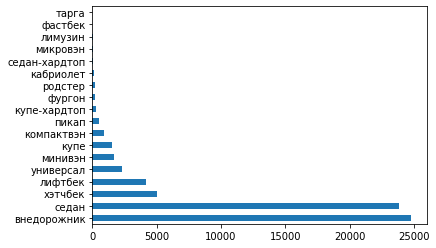

In [126]:
#'bodyType' distribution 
data.bodyType.value_counts().plot.barh() 

In [127]:
cat_cols.append('bodyType')

**brand**

In [128]:
data.brand.value_counts()

BMW            8137
VOLKSWAGEN     8106
NISSAN         7793
MERCEDES       7781
TOYOTA         7445
               ... 
LUXGEN            1
GAC               1
DAIHATSU          1
IRAN_KHODRO       1
SATURN            1
Name: brand, Length: 70, dtype: int64

In [129]:
cat_cols.append('brand')

**color**

In [130]:
data.color.value_counts()

чёрный         20414
белый          12474
серый           8122
серебристый     6977
синий           6171
коричневый      3012
красный         2928
зелёный         1605
бежевый         1205
голубой          830
золотистый       448
пурпурный        443
фиолетовый       362
жёлтый           341
оранжевый        259
розовый           18
Name: color, dtype: int64

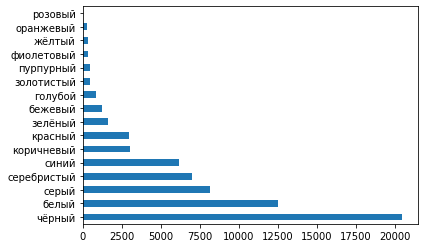

In [131]:
data.color.value_counts().plot.barh() 

It doesn't require additional processing, there are no gaps, we define it as "categorical"

In [132]:
cat_cols.append('color')

**Description**

In [133]:
# description - description, seller comment
# generate a numeric feature - the number of characters in the description
data['description_len'] = data.description.apply(lambda x: len(str(x)))
# drop description after that

In [134]:
data = data.drop('description',axis=1)

In [135]:
#defina as numerical feature
num_cols.append('description_len')

**fuelType**

In [136]:
data.fuelType.value_counts() #categorical feature

бензин     53453
дизель     11599
гибрид       407
электро      137
газ           13
Name: fuelType, dtype: int64

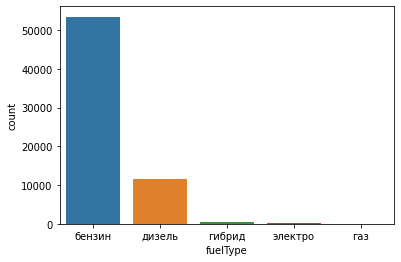

In [137]:
sns.countplot(x = 'fuelType', data = data)

It doesn't require additional processing, there are no gaps, we define it as "categorical"

In [138]:
cat_cols.append('fuelType')

**image**

In [139]:
# image - auto picture
# check the photo for uniqueness
count_photos = data.image.value_counts()
display(count_photos.head(5))

https://avatars.mds.yandex.net/get-verba/216201/2a000001609d0005e0912c12a896bbda4ab1/wizardv3mr     20
https://avatars.mds.yandex.net/get-verba/1030388/2a000001609cf6746b94cf8334836265daaf/wizardv3mr    13
https://avatars.mds.yandex.net/get-verba/216201/2a000001609bda17487cc63d8b957ab4aab2/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016098487a9e1ff58d5ae35f3de345/wizardv3mr     13
https://avatars.mds.yandex.net/get-verba/216201/2a0000016099a4e6be992d7b50134fd908fd/wizardv3mr     12
Name: image, dtype: int64

In [140]:
# get unique photos
display(count_photos.sort_values().head(5))

https://avatars.mds.yandex.net/get-autoru-vos/3926749/a9622c6bf6531bcf0ac3fbfe2e22a1ba/320x240                                                                                                                                   1
https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u0IghxJHqVi5dGL7OcugpPbM0sYLDhB9YWw7CxRKU17ysuJYxuxtaUHk561NRbyjLQrsAgj3CNkWd0oDIyJ7ofxHZYdUDLUH5DIvsWmK9_O-mo6XT34oWVQDBTEybGZikaX4X4bwLyUujf_KICqw3ygs2UNJlXu4Og#DSD    1
https://avatars.mds.yandex.net/get-autoru-vos/2121561/129d18cbcf1513a2f61cd6d7dcb14548/320x240                                                                                                                                   1
https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u0IghxJHqVi5dGL7OcugpPbM0sYLDhB9YWw7CxRKU17ysuJYxuxsaUbm565NS-r-eQ24BV74DIlKeEwFdHN_9f5AMIBSDbBRvDcttGyK9_O-mo6XT34oWVQDBTEybGZikaX4X4bwLyUujf_KICqw3ygs2UNJlXu4Og#DSD    1
https://autoru.naydex.net/o9DBXQ270/5ac010hAY0/Xkcrbmf2u0IghxJHqVi5dGL7OcugpPbM0sYLDhB9YWw7C

In [141]:
# we can make a binary feature out of this by the type of photo uniqueness
data['real_photo'] = data.image.apply(lambda x: x.find('get-verba') == -1)

real = data[data['real_photo'] == False].image.value_counts()
display(real.sort_values().head(5))
# drop 'image' variable 

https://avatars.mds.yandex.net/get-verba/787013/2a000001609d47e6e112bcfda4d0864eeaa0/wizardv3mr    1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609d450e202aa60d859e21010937/wizardv3mr    1
https://avatars.mds.yandex.net/get-verba/937147/2a0000016092153321f229dbcab93392bd11/wizardv3mr    1
https://avatars.mds.yandex.net/get-verba/787013/2a000001609cf9bc691a4c0df4ab7cfaf442/wizardv3mr    1
https://avatars.mds.yandex.net/get-verba/787013/2a00000160971de63671db3acb68d2c05833/wizardv3mr    1
Name: image, dtype: int64

In [142]:
data = data.drop('image',axis=1)

In [143]:
data['real_photo'].value_counts()

True     65046
False      563
Name: real_photo, dtype: int64

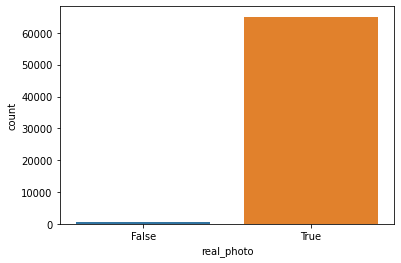

In [144]:
sns.countplot(x = 'real_photo', data = data)

There are more real photos 

In [145]:
bin_cols.append('real_photo')

**engineDisplacement**

In [146]:
data.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', '6.8 LTR', '0.8 LTR', '6.4 LTR', '6.5 LTR', '0.9 LTR',
       '0.6 LTR'], dtype=object)

In [147]:
data.engineDisplacement.value_counts()

2.0 LTR    14515
1.6 LTR     9973
3.0 LTR     7514
1.8 LTR     5805
2.5 LTR     4606
           ...  
6.4 LTR        2
3.9 LTR        1
6.5 LTR        1
0.9 LTR        1
0.6 LTR        1
Name: engineDisplacement, Length: 61, dtype: int64

In [148]:
#leave only the numerical value
data.engineDisplacement = data.engineDisplacement.apply(lambda x: x[:3])
data.engineDisplacement = data.engineDisplacement.replace(' LT', '2.0')
data.engineDisplacement = data.engineDisplacement.apply(lambda x: float(x))

In [149]:
#categorizing
data["engineDisplacement"] = data["engineDisplacement"].astype('float').apply(lambda x: 4 if x >= 4 else 
   3 if x >= 3 else(2 if x >= 2 else (1 if x >= 1 else 0)))
data.engineDisplacement.value_counts()

2    25241
1    22562
3    12254
4     5463
0       89
Name: engineDisplacement, dtype: int64

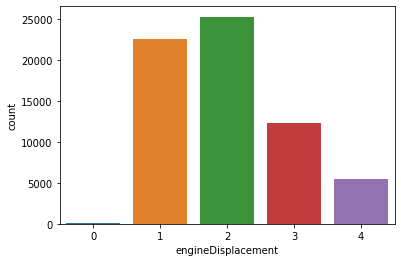

In [150]:
sns.countplot(x = 'engineDisplacement', data = data)

In [151]:
cat_cols.append('engineDisplacement')

**enginePower**

In [152]:
data.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [153]:
#transform data
data['enginePower'] = data['enginePower'].apply(lambda x: x[:3])
data['enginePower'] = data['enginePower'].replace('7 N','7')
data['enginePower'] = data['enginePower'].apply(lambda x: int(x))

<bound method Axes.barh of <matplotlib.axes._subplots.AxesSubplot object at 0x7fb3db850ac0>>

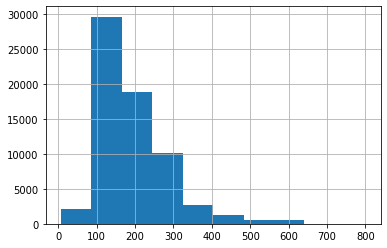

In [154]:
data.enginePower.hist().barh

In [155]:
#add to categorical 
num_cols.append('enginePower')

**mileage**

In [156]:
data['mileage'].value_counts()

200000    448
300000    392
150000    389
250000    364
180000    353
         ... 
242540      1
62844       1
225700      1
86755       1
373317      1
Name: mileage, Length: 25629, dtype: int64

In [157]:
#cleaning data
data['mileage'] = data['mileage'].apply(lambda x: str(x).replace('\xa0км', ''))

In [158]:
data['mileage'] = data.mileage.apply(
    lambda x: int("".join(filter(str.isdigit, x))))

count      65609.000000
mean      152734.059931
std        98234.485146
min            1.000000
25%        82450.000000
50%       140000.000000
75%       202667.000000
max      1000000.000000
Name: mileage, dtype: float64

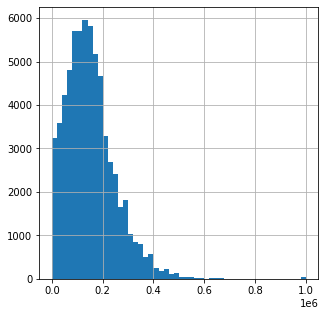

In [159]:
data['mileage'].hist(figsize=(5,5), bins=50)
data.mileage.describe()

In [160]:
#create categorical feature 'mileage_cat'  
data["mileage_cat"] = data["mileage"].apply(lambda x: 4 if x>=40000 else(3 if x>=30000 else(2 if x>=20000 else (1 if x>=10000 else 0))))

In [161]:
data.mileage_cat.value_counts()

4    58896
3     1845
2     1699
1     1595
0     1574
Name: mileage_cat, dtype: int64

In [162]:
num_cols.append('mileage')
cat_cols.append('mileage_cat')

**productionDate и modelDate**

In [163]:
data.productionDate.value_counts()

2012    5382
2013    4933
2011    4772
2014    4467
2008    4410
        ... 
1936       1
1949       1
1970       1
1938       1
1962       1
Name: productionDate, Length: 74, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


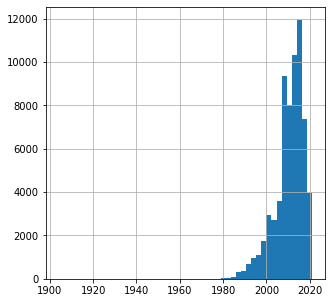

In [164]:
print(data['productionDate'].hist(figsize=(5,5), bins=50))

In [165]:
data.modelDate.value_counts()

2013    4646
2012    4616
2011    4340
2014    4191
2010    4056
        ... 
1965       1
1946       1
1934       1
1952       1
1950       1
Name: modelDate, Length: 73, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


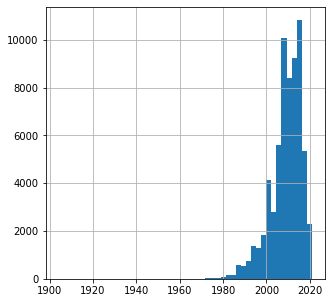

In [166]:
print(data['modelDate'].hist(figsize=(5,5), bins=50))

In [167]:
#create new features based on the existing ones: the number of years of production and the age of the model
data['prod_age'] = 2021 - data.productionDate
data['model_age'] = 2021 - data.modelDate

In [168]:
#define these features into numerical data
num_cols.append('productionDate')
num_cols.append('modelDate')
num_cols.append('prod_age')
num_cols.append('model_age')

**model_name**

In [169]:
data.model_name.unique()

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', ..., 'VAMOS', 'CAPA', 'MDX'],
      dtype=object)

In [170]:
cat_cols.append('model_name')

**numberOfDoors**

In [171]:
data.numberOfDoors.value_counts() #categorical feature,it doesn't require additional processing

5    36866
4    25512
2     2129
3     1101
0        1
Name: numberOfDoors, dtype: int64

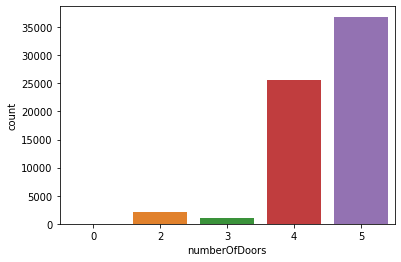

In [172]:
sns.countplot(x = 'numberOfDoors', data = data)

In [173]:
cat_cols.append('numberOfDoors')

**sell_id**

In [174]:
test.sell_id.isna().sum()

0


sell_id - the identifier of the ad that we have in the test collection. The report shows that this feature is unique, there are no gaps left. The feature is the ID of the ad. Does not carry a semantic load, we do not select for training

**vehicleTransmission**

In [175]:
data.vehicleTransmission.value_counts()

автоматическая      37639
механическая        12662
роботизированная     7798
вариатор             7510
Name: vehicleTransmission, dtype: int64

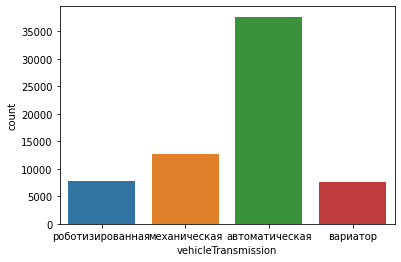

In [176]:
sns.countplot(x = 'vehicleTransmission', data = data)

In [177]:
#define as categorical
cat_cols.append('vehicleTransmission')

**owners**

In [178]:
data['owners'].value_counts()

3 или более    27688
1 владелец     11879
2 владельца    10713
1 владелец      8517
2 владельца     6812
Name: owners, dtype: int64

In [179]:
#clean up the data, leave only the number of owners
data['owners'] = data['owners'].apply(lambda x: int(x[0])).astype('int32')

In [180]:
data.owners.value_counts()

3    27688
1    20396
2    17525
Name: owners, dtype: int64

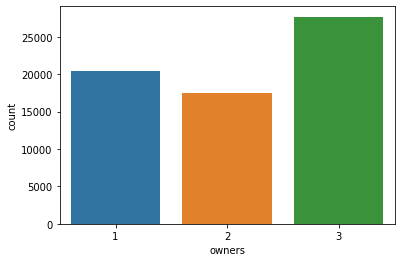

In [181]:
sns.countplot(x = 'owners', data = data)

In [182]:
cat_cols.append('owners')

**vehicle_licence**

In [183]:
data.vehicle_licence.value_counts()

Оригинал    57486
Дубликат     8122
Name: vehicle_licence, dtype: int64

In [184]:
data.vehicle_licence.isna().sum()

1

In [185]:
data.vehicle_licence = data.vehicle_licence.fillna('Оригинал')# fill in the gap with the most common value

In [186]:
# Let's transform the values in 'vehicle_licence'
data['vehicle_licence'] = data['vehicle_licence'].apply(lambda x: 1 if x == 'Оригинал' else 0).astype('int8')

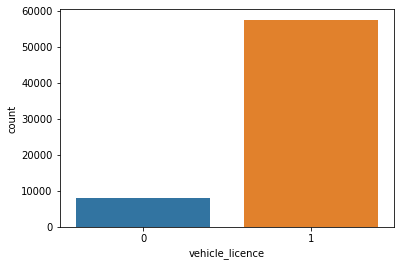

In [187]:
sns.countplot(x = 'vehicle_licence', data = data)

In [188]:
#define binary features
bin_cols.append('vehicle_licence')

**Привод**

In [189]:
data.drive_type.value_counts()

передний    29352
полный      29242
задний       7015
Name: drive_type, dtype: int64

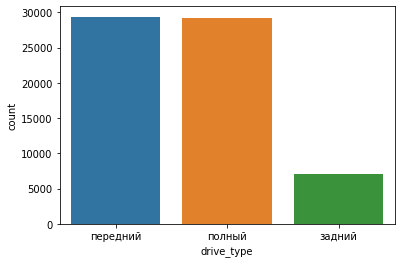

In [190]:
#посмотрим на распределение
sns.countplot(x = 'drive_type', data = data)

In [191]:
cat_cols.append('drive_type')

**Wheel**

In [192]:
data.wheel.value_counts()

Левый     63355
Правый     2254
Name: wheel, dtype: int64

In [193]:
# Преобразуем значения в колонке Руль
data['wheel'] = data['wheel'].apply(lambda x: 1 if x == 'Левый' else 0).astype('int8')

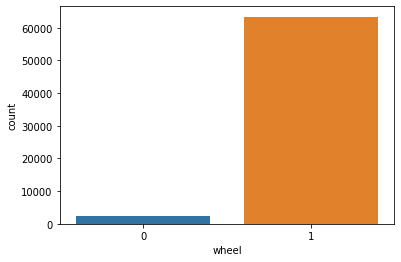

In [194]:
sns.countplot(x = 'wheel', data = data)

In [195]:
bin_cols.append('wheel')

**condition**

In [196]:
data.condition.unique()

array(['Не требует ремонта', 'Битый / не на ходу'], dtype=object)

In [197]:
# Преобразуем значения в колонке Состояние
data['condition'] = data['condition'].apply(lambda x: 1 if x == 'Не требует ремонта' else 0).astype('int8')

In [198]:
data.condition.value_counts()

1    65607
0        2
Name: condition, dtype: int64

In [199]:
bin_cols.append('condition')

**Target variable distribution:**

In [200]:
#to a numeric type
data['price'] = data['price'].apply(lambda x: str(x))

In [201]:
data.price = data.price.apply(
    lambda x: ("".join(filter(str.isdigit, x)))).astype('int')

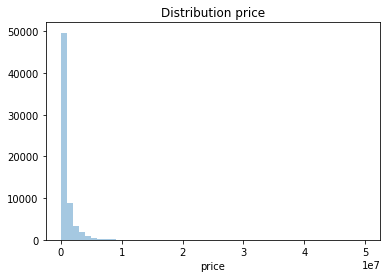

In [202]:
plt.figure()
plt.title(f"Distribution {'price'}")
sns.distplot(data.price, kde=False)

Let's look at the distribution of the dependence of the price on the brand of car:

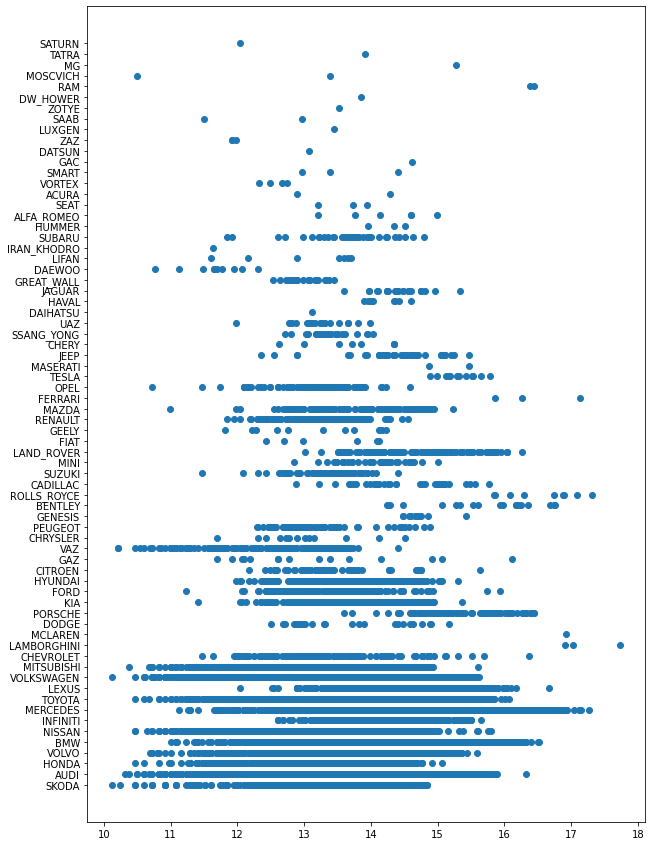

In [203]:
plt.figure(figsize=(10, 15))
plt.scatter(np.log(data.price), data.brand)

Shows that the prices are adequate and depend on the brand of car

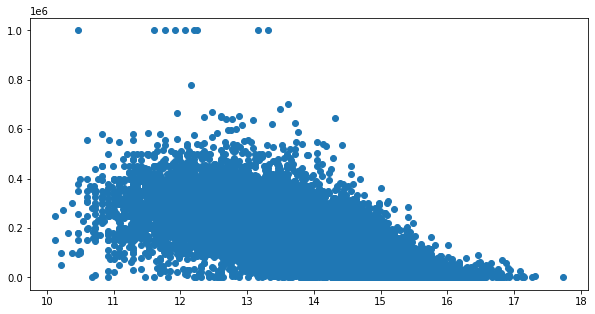

In [204]:
#Let's look at the distribution of price dependence on mileage
plt.figure(figsize=(10, 5))
plt.scatter(np.log(data.price), data.mileage)

Let's remove variables that, in our opinion, do not have any information content, or duplicate information:

In [205]:
data = data.drop(columns = ['car_url','name','sell_id','parsing_unixtime','vehicleConfiguration','priceCurrency','customs_clearance'], axis=1)

In [206]:
data.head(2)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,owners,vehicle_licence,drive_type,wheel,condition,price,sample,description_len,real_photo,mileage_cat,prod_age,model_age
0,лифтбек,SKODA,синий,1,105,бензин,74000,2013,OCTAVIA,5,2014,роботизированная,3,1,передний,1,1,0,0,1001,True,4,7,8
1,лифтбек,SKODA,чёрный,1,110,бензин,60563,2017,OCTAVIA,5,2017,механическая,1,1,передний,1,1,0,0,2609,True,4,4,4


## Label Encoding

In [207]:
for colum in ['bodyType','color','model_name','brand','fuelType', 'vehicleTransmission','drive_type','real_photo']:
    data[colum] = data[colum].astype('category').cat.codes

In [210]:
print('Categorical: {} \nBinary: {}\nNumerical: {}'.format(cat_cols, bin_cols,num_cols))

Categorical: ['bodyType', 'brand', 'color', 'fuelType', 'engineDisplacement', 'mileage_cat', 'model_name', 'numberOfDoors', 'vehicleTransmission', 'owners', 'drive_type'] 
Binary: ['real_photo', 'vehicle_licence', 'wheel', 'condition']
Numerical: ['description_len', 'enginePower', 'mileage', 'productionDate', 'modelDate', 'prod_age', 'model_age']


# Binary features

In [208]:
for i in bin_cols:
    display(data[i].value_counts())

1    65046
0      563
Name: real_photo, dtype: int64

1    57487
0     8122
Name: vehicle_licence, dtype: int64

1    63355
0     2254
Name: wheel, dtype: int64

1    65607
0        2
Name: condition, dtype: int64

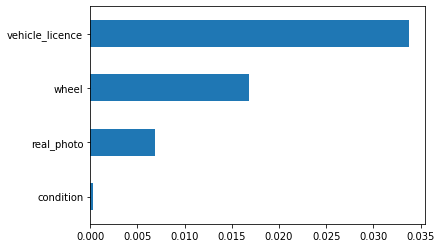

In [211]:
# Let's check the significance of binary variables:
df = data[data['sample'] == 0]
imp_cat = Series(mutual_info_classif(data[bin_cols], data['price'],
                                     discrete_features =True), index = bin_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

observing the plot, we see that 'vehicle_licence' and 'wheel' have the most influence on the price

<AxesSubplot:>

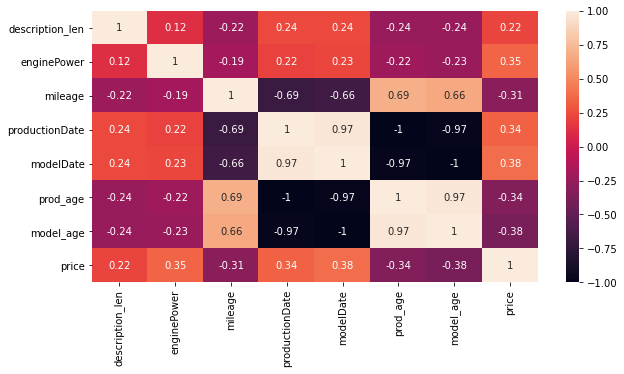

In [ ]:
# build a correlation matrix for numerical features
plt.figure(figsize=(10,5))
sns.heatmap(data[num_cols+['price']].corr(), annot=True)

# Categorical features

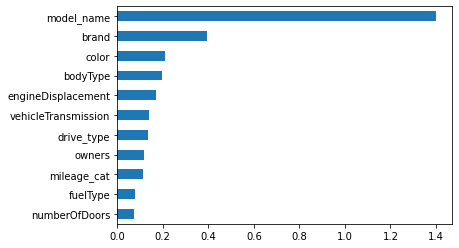

In [212]:
# Let's check the significance of categorical variables:
temp_df = data[data['sample']==1]
imp_cat = Series(mutual_info_classif(data[cat_cols], data['price'],
                                     discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

It is logical that the price will depend on the brand and model of the car

# Numerical variables

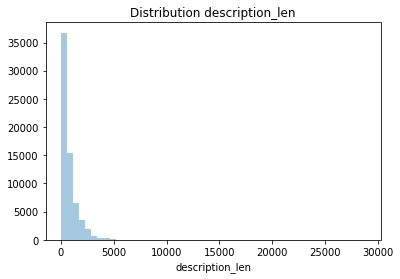

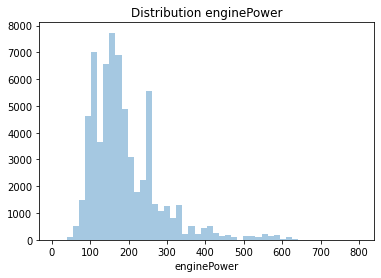

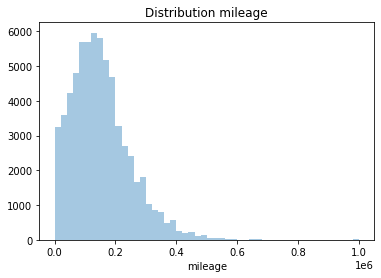

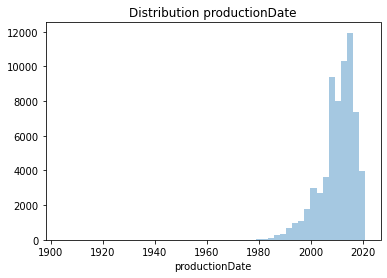

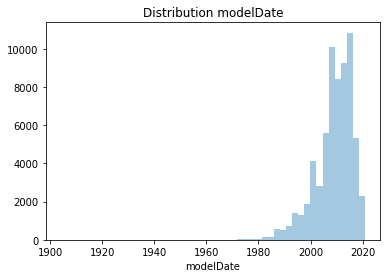

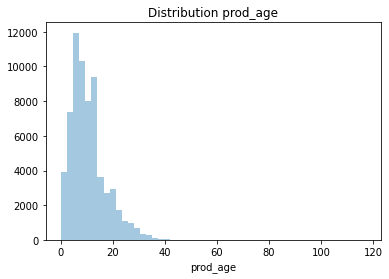

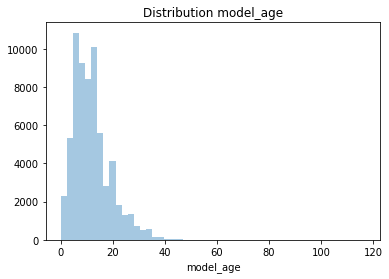

In [213]:
# distribution of numerical variables using visualization
for col in num_cols:
    plt.figure()
    plt.title(f"Distribution {col}")
    sns.distplot(data[col], kde=False)

<AxesSubplot:>

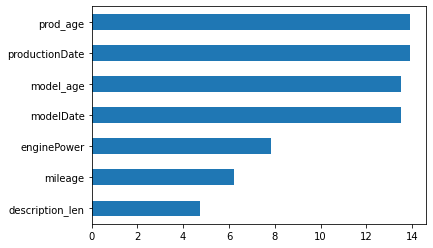

In [ ]:
imp_num = Series(f_classif(data[num_cols][data['sample'] == 1], data[data['sample'] == 1]['price'])[0], 
                 index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

All features have a strong effect on the price.

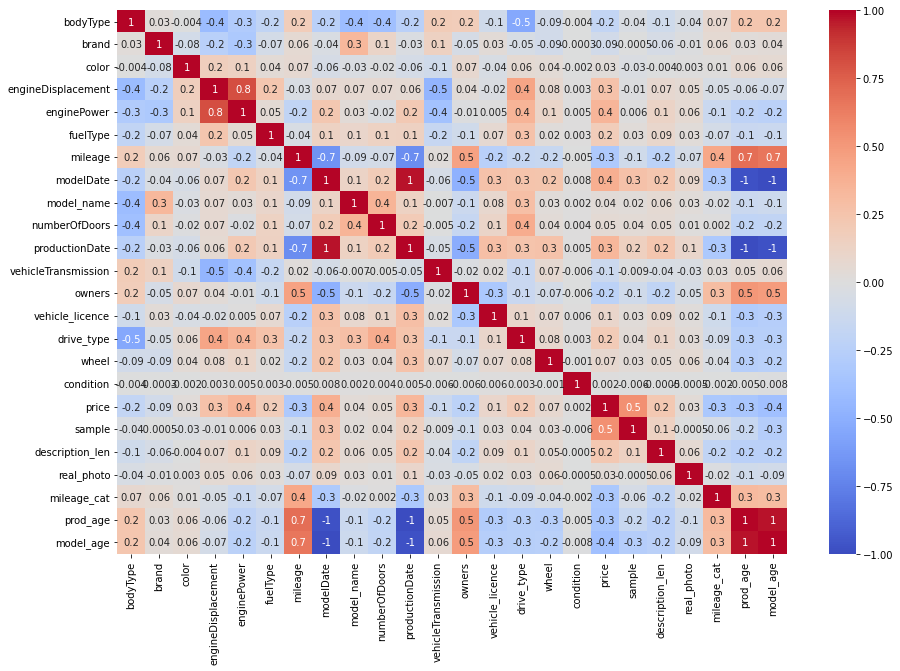

In [216]:
# correlation

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax = sns.heatmap(data.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

There is a strong correlation between the 'engineDisplacement' and 'enginePower' features, as well as artificially created features. We will not delete it, because after conducting experiments on machine learning, we noticed that the result of the metric is worse.

## Train Split

In [217]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample','price'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# Model 1: create a basic model
This model will predict the average price of the engine model (engineDisplacement).
We will compare other models with it.




In [219]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [220]:
# Find median by instances of engineDisplacement in the train and mark up the test
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())
VERSION = 1
#checking accuracy
print(f"MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

MAPE: 95.03%


# Simple linear regression model

In [221]:
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression().fit(X_train, np.log(y_train+1))
VERSION = 2
predict_test = np.exp(linear_regr.predict(X_test))
print(f"MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

MAPE: 25.60%


# CatBoost


In [222]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [224]:
# checking accuracy
VERSION = 3
predict = model.predict(X_test)
print(f"MAPE: {(mape(y_test, predict))*100:0.2f}%")

MAPE: 14.91%


### Log Target
Let's try to take the target in the logarithm. This will reduce the impact of outliers on model training (we use np.log and np.exp for this).

In [ ]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')
predict_test = np.exp(model.predict(X_test))
#predict_submission = np.exp(model.predict(test_data))
VERSION = 4
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 12.52%


# Random Forest

In [ ]:
rf = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1).fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(rf.predict(X_test))))*100:0.2f}%")
VERSION = 5
#predict_submission = np.exp(rf.predict(test_data))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s


Точность модели по метрике MAPE: 14.19%


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


**Comment it out, it takes a lot of time:**

In [ ]:
#Define a grid of hyperparameters that will be iterated:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
#training:
#rf = RandomForestRegressor(random_state=42)
#rf_rand = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
#                              cv=3, verbose=2, random_state=42, n_jobs=-1)
#rf_random.fit(X_train, np.log(y_train+1))

In [ ]:
#print(f"MAPE: {(mape(y_test, np.exp(rf.predict(X_test))))*100:0.2f}%")
VERSION = 6
#predict_submission = np.exp(rf_random.predict(test_data))


# xgboost

In [ ]:
# xgboost
import xgboost as xgb
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
xb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test))))*100:0.2f}%")
VERSION = 7
predict_test = np.exp(xb.predict(X_test))
predict_submission = np.exp(xb.predict(test_data))

Точность модели по метрике MAPE: 12.14%


# GradientBoosting with hyperparameter tuning

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
def regularise(X_train, y_train):
    max_depth = [5, 10,15]
    n_estimators = [100, 200,1000]
    hyperparameters = dict(max_depth=max_depth, n_estimators=n_estimators)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters)

    best_model = clf.fit(X_train, y_train)

    best_max_depth = best_model.best_estimator_.get_params()['max_depth']
    best_n_estimators = best_model.best_estimator_.get_params()['n_estimators']

    return best_max_depth, best_n_estimators

In [ ]:
#VERY LONG WORK, COMMENT it
#best_max_depth, best_n_estimators = regularise(X_train, y_train)
#best_max_depth, best_n_estimators

(5, 1000)

In [ ]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=5, n_estimators=1000)
gb.fit(X_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(gb.predict(X_test))))*100:0.2f}%")
VERSION = 8

Точность модели по метрике MAPE: 13.81%


# Stacking

In [ ]:
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test) 


y_train = y_train 
y_test = y_test

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def compute_meta_feature(regr, X_train, X_test, y_train, cv):
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)    
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_regr = clone(regr)
        folded_regr.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_regr.predict(X_fold_predict)

    meta_regr = clone(regr)
    meta_regr.fit(X_train, y_train)

    X_meta_test = meta_regr.predict(X_test)


    return X_meta_train, X_meta_test

def generate_meta_features(regr, X_train, X_test, y_train, cv):
    features = [compute_meta_feature(regr, X_train, X_test, y_train, cv) for regr in tqdm(regr)]    
    stacked_features_train = np.vstack([features_train for features_train, features_test in features]).T
    stacked_features_test = np.vstack([features_test for features_train, features_test in features]).T
    return stacked_features_train, stacked_features_test

X_train = np.where(np.isnan(X_train), 0, X_train)
X_test = np.where(np.isnan(X_test), 0, X_test)
y_train = np.where(np.isnan(y_train), 0, y_train)

In [ ]:
regr = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, 
                             max_features=3, max_depth=19, bootstrap=True, random_state=RANDOM_SEED)

stacked_features_train, stacked_features_test = generate_meta_features([
                            regr,
                            GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=300),
                            KNeighborsRegressor(n_neighbors=2, algorithm = 'ball_tree', weights = 'distance', p=1),
                            RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1, max_depth=5, n_estimators=200),
                            ExtraTreesRegressor(random_state=RANDOM_SEED), 
                            RandomForestRegressor(random_state=RANDOM_SEED, max_depth=15) \
], X_train, X_test, y_train, cv)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 task

In [ ]:
def compute_metric(regr, X_train, y_train, X_test, y_test): 
    regr.fit(X_train, y_train) 
    y_test_pred = regr.predict(X_test) 
    return np.round(mape(y_test, y_test_pred)*100, 2)
VERSION = 9
print(f"Точность модели по метрике MAPE: {compute_metric(regr, stacked_features_train, y_train, stacked_features_test, y_test)}%")

Точность модели по метрике MAPE: 14.71%


After a series of experiments, we can make the following conclusions:
* CatBoost and GradientBoosting do a great job and show a good metric result, but xgboost showed the best result - 12.14.
* The result significantly improves  after taking the logarithm of the target variable
* also managed to experiment with staking with different meta-algorithms.

The results can be improved by parsing more data and doing more processing on the features by creating new ones, but due to lack of time this was not done.

# Submission

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.697804e+05
1,1100549428,9.962137e+05
2,1100658222,9.239507e+05
3,1100937408,7.974400e+05
4,1101037972,7.523437e+05
5,1100912634,7.435708e+05
6,1101228730,6.611716e+05
7,1100165896,4.483103e+05
8,1100768262,2.138524e+06
9,1101218501,8.035688e+05


# What's next?
Or what else can be done to improve the result:

* Parse fresh data
* See what can be extracted from the features or how else the features can be processed
* Generate new features
* Try to find model parameters
* Try other algorithms and ML libraries
* Make Model Ensemble, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing